# 멋진 작사가 만들기


## 1. 첫시도

- BATCH_SIZE = 256 -> 128 로 적용
- 모델의 Embedding Size : 256 -> 512 로 변경, Hidden Size : 1024(변경없음) 적용

## 라이브러리 import

In [1]:
import re 
import numpy as np
import tensorflow as tf

## 데이터 읽어오기
___

- **`glob` 모듈을 사용하여 파일을 읽어오기**
- **모든 `txt` 파일을 읽어온 후, `raw_corpus` 리스트에 문장 단위로 저장!**



In [2]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:5])


데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth']


## 데이터 정제
___

- **`preprocess_sentence()` 함수를 사용하여 데이터 정제.**
- **지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거.**

In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지움
#     2. 특수문자 양쪽에 공백 삽입
#     3. 여러개의 공백은 하나의 공백으로 바꿈
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿈
#     5. 다시 양쪽 공백을 지움
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보자.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


- **공백인 문장은 길이를 검사하여 길이가 0이라면 제외**
- **토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외**

In [4]:
# 여기에 정제된 문장을 모음
corpus = []

for sentence in raw_corpus:
    # 원하지 않는 문장은 건너뜀
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # split()메소드로 단어 15개 이상 건너뜀
    if len(preprocessed_sentence.split()) > 15: continue
        
    corpus.append(preprocessed_sentence)
        
# 정제된 결과 10개 확인
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer, pad_sequences 사용

def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만듦
    # 이미 문장을 정제했으니 filters가 필요없음
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿈
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춤
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f0fb5f5dd30>


- **생성된 텐서 데이터를 65번째부터 10행까지만 출력해 확인해 본다.**

In [6]:
print(tensor[64:74, :])

[[   2  175  317  175  317   15    6 1566   26 7678    3    0    0    0
     0]
 [   2  175  317   15    6 2425 1710    3    0    0    0    0    0    0
     0]
 [   2  175   37   41  494  337    3    0    0    0    0    0    0    0
     0]
 [   2   23  223  632  107  223  536   32  731    3    0    0    0    0
     0]
 [   2  175  431   10  223 1336    3    0    0    0    0    0    0    0
     0]
 [   2  175  607    9  900   20 6829    3    0    0    0    0    0    0
     0]
 [   2    8    9  168 5381 1165    3    0    0    0    0    0    0    0
     0]
 [   2  175  317  175  317   15    7   36   12   52    3    0    0    0
     0]
 [   2  175  317   15    7  164   48    3    0    0    0    0    0    0
     0]
 [   2  175  317   15    7   95  105 3173    3    0    0    0    0    0
     0]]


- **단어 사전이 어떻게 구축되었는지 아래와 같이 확인**

In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## 평가 데이터셋 분리
___

### ***훈련 데이터와 평가 데이터를 분리!***

- `tokenize()` 함수로 데이터를 Tensor로 변환한 후, 
- `sklearn` 모듈의 `train_test_split()` 함수를 사용해 훈련 데이터와 평가 데이터를 분리.
- **단어장의 크기는 12,000**!
- **총 데이터의 20%** 를 평가 데이터셋으로 사용!

In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6269    3    0    0    0]
[  50    4   95  303   62   53    9  946 6269    3    0    0    0    0]


In [9]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 15) 

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val:", enc_val.shape)
print("Target Val:", dec_val.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)
Source Val: (31246, 14)
Target Val: (31246, 14)


- **model.summary() 확인용**

In [10]:
BUFFER_SIZE = len(enc_train) #텐서의 1차원, 전체 문장의 개수
BATCH_SIZE = 128        #문장의 개수
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개 + 0:<pad>를 포함
VOCAB_SIZE = tokenizer.num_words + 1

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
# dataset = tf.data.Dataset.from_tensor_slices((enc_val_train, dec_val_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((128, 14), (128, 14)), types: (tf.int32, tf.int32)>

## 인공지능 만들기
___

- **모델의 Embedding Size = 512로 조절하여 10 Epoch 안에 `val_loss` 값을 2.2 아하로 모델 설계!**


In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512  #단어 하나의 특징 수
hidden_size = 1024    #퍼셉트론의 개수
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [12]:
# 데이터셋에서 데이터 한 배치만 불러와서 임시 모델 생성 및 확인
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(128, 14, 12001), dtype=float32, numpy=
array([[[ 2.2828850e-05,  5.1902159e-04,  2.9014645e-04, ...,
         -3.1061580e-05,  1.2831355e-04, -1.6740520e-04],
        [ 6.2272785e-04,  6.1133143e-04,  6.1405235e-04, ...,
          1.1995664e-04,  3.9273695e-04, -1.6417052e-04],
        [ 1.2268894e-03,  4.8101216e-04,  7.9033722e-04, ...,
          2.7912183e-04,  5.9017254e-04, -2.8152767e-04],
        ...,
        [ 1.6767555e-03,  2.1154208e-04,  7.7606608e-05, ...,
          1.2235155e-03,  9.0915768e-04, -3.7487381e-04],
        [ 1.4596393e-03,  2.8394168e-04,  3.5734585e-04, ...,
          8.2349981e-04,  6.2528660e-04, -6.4893637e-04],
        [ 1.0099153e-03,  4.0639611e-04,  8.3577196e-04, ...,
          4.4392890e-04,  1.6132230e-04, -9.7023067e-04]],

       [[ 2.2828850e-05,  5.1902159e-04,  2.9014645e-04, ...,
         -3.1061580e-05,  1.2831355e-04, -1.6740520e-04],
        [ 2.1478291e-04,  1.1100408e-03,  2.8053846e-04, ...,
         -2.4341368e-04, 

In [13]:
# 생성된 모델 살펴보기
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6144512   
_________________________________________________________________
lstm (LSTM)                  multiple                  6295552   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 33,133,793
Trainable params: 33,133,793
Non-trainable params: 0
_________________________________________________________________


In [14]:
# optimizer 와 loss function 지정

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=128, validation_data = (enc_val, dec_val))



Epoch 1/10
977/977 [==============================] - 111s 111ms/step - loss: 3.2813 - val_loss: 2.9966
Epoch 2/10
977/977 [==============================] - 109s 111ms/step - loss: 2.8501 - val_loss: 2.8055
Epoch 3/10
977/977 [==============================] - 109s 111ms/step - loss: 2.6552 - val_loss: 2.6882
Epoch 4/10
977/977 [==============================] - 109s 111ms/step - loss: 2.4920 - val_loss: 2.6026
Epoch 5/10
977/977 [==============================] - 109s 111ms/step - loss: 2.3440 - val_loss: 2.5375
Epoch 6/10
977/977 [==============================] - 109s 111ms/step - loss: 2.2074 - val_loss: 2.4890
Epoch 7/10
977/977 [==============================] - 109s 111ms/step - loss: 2.0805 - val_loss: 2.4510
Epoch 8/10
977/977 [==============================] - 109s 111ms/step - loss: 1.9626 - val_loss: 2.4221
Epoch 9/10
977/977 [==============================] - 109s 111ms/step - loss: 1.8529 - val_loss: 2.4050
Epoch 10/10
977/977 [==============================] - 109s 111m

In [15]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [16]:
generate_text(model, tokenizer, init_sentence="<start> am", max_len=20)

'<start> am i scary for you <end> '

In [17]:
generate_text(model, tokenizer, init_sentence="<start> talking", max_len=20)

'<start> talking bout what i m saying , <end> '

In [18]:
generate_text(model, tokenizer, init_sentence="<start> will", max_len=20)

'<start> will you still love me tomorrow , can t you see ? <end> '

In [19]:
generate_text(model, tokenizer, init_sentence="<start> won t", max_len=20)

'<start> won t you come on over <end> '

## 모델이 생성한 가사를 보고 느낀 점

- 첫 느낌은 "제법 노래 가사다운 가사가 만들어진다" 라는 생각이 들었고 임의의 첫글자를 `<start>` 가사로 랜덤하게 떠오르는 단어들로 모델에 넣어보았는데 "잘 만들어진 가사!!?" 이런 느낌이었다. 모델이 생성한 가사를 바탕으로 수정해서 만들어도 되겠다는 생각을 해보았다.
- 제법 신선한 경험이었다고 생각된다. ***여러분의 모델은 어떤가요?***



## - 첫시도 회고

- 최초 초기값에서 batch_size와 Embedding Size를 변경하여 작업해 보았으나 `val_loss`의 큰 변화는 없었다고 판단된다.
- 그 원인이 무엇인지는 아직은 정확하게 파악하기 힘들다. 과적합의 문제인지 하이퍼 파라미터의 최적화 문제인지 혹은 다른 문제가 있는것은 아니지......
- 텍스트 제너레이션 결과가 위에서 말한바와 같이 제법 그럴싸하게 생성되었다고 판단했다.
  다만, 문장의 길이가 다소 짧은 문장 위주로 만들어져서 val_loss를 더 낮추면 좀 더 멋진 문장이 나오리라 생각된다.
- `val_loss` 가 **2.38**로 노드에서 제시한 기준에 미치지 못했기에 두번째 시도에서 달성해 보려한다.
___

- Load한 txt 파일중에 아래와 같이 비슷한 파일명이 있어 내용을 확인해 보니 `내용이 서로 똑같은 파일과 일부만 다른 파일`과 같이 두가지 사례가 있었다. 그 파일들은 아래를 참고 바란다.

>- Kanye_West.txt 와 kanye-west.txt 
>- notorious_big.txt 와 notorious-big.txt

- 파일의 내용을 들여다보면 두 파일이 중복되는 부분들이 있어서 노드에서 제시한 124,960 과는 차이가 발생할 수 밖에 없는 것으로 판단했다.
- 큰 차이는 아니라서 그대로 진행해 보았고 데이터를 정제 후에는 어떻게 달라질지는 추후에 시간적 여유를 가지고 해보려 한다.


___

## 2. 두번째 시도

### 첫시도 대비 변경사항

- loss 시각화 
- BATCH_SIZE = 128 -> 256 으로 변경
- 모델의 Embedding Size : 512 -> 256 으로 변경, Hidden Size : 1024 -> 2048로 변경 적용
- `train_test_split()` 함수를 사용해 분리한 훈련 데이터에서 재분리 시도

## 데이터 읽어오기
___

- **`glob` 모듈을 사용하여 파일을 읽어오기**
- **모든 `txt` 파일을 읽어온 후, `raw_corpus` 리스트에 문장 단위로 저장!**



In [20]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:5])


데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth']


## 데이터 정제
___

- **`preprocess_sentence()` 함수를 사용하여 데이터 정제.**
- **지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거.**


In [21]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지움
#     2. 특수문자 양쪽에 공백 삽입
#     3. 여러개의 공백은 하나의 공백으로 바꿈
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿈
#     5. 다시 양쪽 공백을 지움
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보자.
print(preprocess_sentence("This @_is ;;;sample ^-^* :-:  _ %_% -  sentence."))

<start> this is sample sentence . <end>


- **공백인 문장은 길이를 검사하여 길이가 0이라면 제외**
- **토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외**

In [22]:
# 여기에 정제된 문장을 모음
corpus = []

for sentence in raw_corpus:
    # 원하지 않는 문장은 건너뜀
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # split()메소드로 단어 15개 이상 건너뜀
    if len(preprocessed_sentence.split()) > 15: continue  
        
    corpus.append(preprocessed_sentence)
        
# 정제된 결과 10개 확인
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [23]:
# 토큰화 할 때 텐서플로우의 Tokenizer, pad_sequences 사용

def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만듦
    # 이미 문장을 정제했으니 filters가 필요없음
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿈
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춤
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f0f9c0db850>


## 평가 데이터셋 분리
___

### ***훈련 데이터와 평가 데이터를 분리!***

- `tokenize()` 함수로 데이터를 Tensor로 변환한 후, 
- `sklearn` 모듈의 `train_test_split()` 함수를 사용해 분리한 훈련 데이터를 재분리.
- **단어장의 크기는 12,000**!



In [24]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6269    3    0    0    0]
[  50    4   95  303   62   53    9  946 6269    3    0    0    0    0]


In [27]:
from sklearn.model_selection import train_test_split

# 훈련, 테스트 세트 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 15) 
# 훈련, 검증 세트 분리
enc_val_train, enc_val_val, dec_val_train, dec_val_val = train_test_split(enc_train, dec_train, test_size = 0.125 ,\
                                                                          random_state = 15) 
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val test:", enc_val.shape)
print("Target Val test:", dec_val.shape)
print("Source Val Val:", enc_val_val.shape)
print("Target Val Val:", dec_val_val.shape)


Source Train: (124981, 14)
Target Train: (124981, 14)
Source Val test: (31246, 14)
Target Val test: (31246, 14)
Source Val Val: (15623, 14)
Target Val Val: (15623, 14)


- **model.summary() 확인용**

In [28]:
BUFFER_SIZE = len(enc_train) #텐서의 1차원, 전체 문장의 개수
BATCH_SIZE = 256        #문장의 개수
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개 + 0:<pad>를 포함
VOCAB_SIZE = tokenizer.num_words + 1

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
# dataset = tf.data.Dataset.from_tensor_slices((enc_val_train, dec_val_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 인공지능 만들기
___

- **모델의 Hidden Size = 2048로 조절하여 10 Epoch 안에 `val_loss` 값을 2.2 이하로 모델 설계!**


In [29]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
#         self.drop = tf.keras.layers.Dropout(0.5)
        out = self.linear(out)
        
        return out
    
embedding_size = 256  #단어 하나의 특징 수
hidden_size = 2048    #퍼셉트론의 개수
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [30]:
# 데이터셋에서 데이터 한 배치만 불러와서 임시 모델 생성 및 확인
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.95437184e-04, -3.52773095e-05,  1.15309791e-04, ...,
         -5.33314305e-05,  2.59980123e-04, -1.30623652e-04],
        [-4.55428293e-04,  3.44728032e-05, -1.21135694e-04, ...,
         -7.96695676e-05,  5.56986022e-04, -1.74602144e-04],
        [-2.76521983e-04, -5.36673870e-05, -2.27313038e-04, ...,
         -7.12502151e-05,  8.64925329e-04, -1.58952935e-05],
        ...,
        [ 1.25842989e-05, -8.07101082e-04,  1.95235002e-03, ...,
         -1.02602493e-03,  1.19710469e-03, -3.05485330e-03],
        [ 1.31849389e-04, -1.01104868e-03,  2.12386181e-03, ...,
         -9.59711382e-04,  1.18882011e-03, -3.40699893e-03],
        [ 2.58464366e-04, -1.20933005e-03,  2.25572661e-03, ...,
         -9.09548660e-04,  1.18796888e-03, -3.70446243e-03]],

       [[-1.95437184e-04, -3.52773095e-05,  1.15309791e-04, ...,
         -5.33314305e-05,  2.59980123e-04, -1.30623652e-04],
        [ 1.26048559e-04, -1.00197765e-04, -2

In [31]:
# 생성된 모델 살펴보기
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  18882560  
_________________________________________________________________
lstm_3 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_1 (Dense)              multiple                  24590049  
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


In [32]:
# optimizer 와 loss function 지정

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=256, validation_data = (enc_val_val, dec_val_val))



Epoch 1/10
489/489 [==============================] - 240s 487ms/step - loss: 3.3447 - val_loss: 2.9494
Epoch 2/10
489/489 [==============================] - 243s 496ms/step - loss: 2.8272 - val_loss: 2.6249
Epoch 3/10
489/489 [==============================] - 244s 498ms/step - loss: 2.5590 - val_loss: 2.3410
Epoch 4/10
489/489 [==============================] - 244s 498ms/step - loss: 2.3006 - val_loss: 2.0644
Epoch 5/10
489/489 [==============================] - 244s 498ms/step - loss: 2.0502 - val_loss: 1.8094
Epoch 6/10
489/489 [==============================] - 243s 498ms/step - loss: 1.8124 - val_loss: 1.5842
Epoch 7/10
489/489 [==============================] - 244s 499ms/step - loss: 1.5969 - val_loss: 1.3908
Epoch 8/10
489/489 [==============================] - 244s 498ms/step - loss: 1.4119 - val_loss: 1.2341
Epoch 9/10
489/489 [==============================] - 244s 499ms/step - loss: 1.2611 - val_loss: 1.1155
Epoch 10/10
489/489 [==============================] - 244s 499m

### loss 시각화

- **아래 그래프 확인하여 validation loss가 제대로 나왔는지 알아보자.**

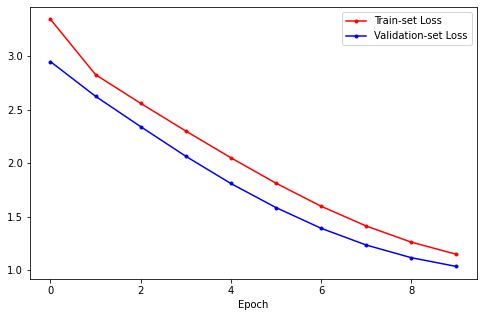

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [34]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [35]:
generate_text(model, tokenizer, init_sentence="<start> am", max_len=20)

'<start> am i too loud for you ? <end> '

In [36]:
generate_text(model, tokenizer, init_sentence="<start> talking", max_len=20)

'<start> talking to the moon <end> '

In [37]:
generate_text(model, tokenizer, init_sentence="<start> will", max_len=20)

'<start> will you still love me ? <end> '

In [38]:
generate_text(model, tokenizer, init_sentence="<start> won t", max_len=20)

'<start> won t you come see me , queen jane ? <end> '

## - 두번째 시도 회고

- train_test_split() 함수를 사용해 분리한 훈련 데이터를 재분리하여 학습을 시켰더니 val_loss 가 **2.2** 이하로 떨어졌다.
  이를 분석해 보면 한번 분리한 훈련데이터에서 검증 세트로 분리한 한것이기 때문에 이미 훈련데이터에 있는 데이터를 재분리 하였기에
  데이터의 교집합에 생겨서 향상된 것으로 분석해 보았다. 이 방법이 정상적인 방법은 아닌것으로 판단된다.
- 하지만 두번째 시도를 마치고 모델이 작사한 가사를 보았을 때 "처음 드는 생각은 가사가 길어졌다!!" 였다.
- 첫시도 가사와 '<start>'를 동일한 단어를 입력했더니 위와 같이 나왔다.
- 제대로 학습했다고는 할 수 없지만 정말 가사로 사용할 수 있겠다고 생각되었다.


___

## 3. 세번째 시도

- BATCH_SIZE = 64, 128, 256, 512 등 다양
- 모델의 Embedding Size : 128, 256, 512 등, Hidden Size : 256, 512, 1024, 2048 등 다양
- dropout 적용 등 다양하게 하이파 파라미터를 조정해서 시도해 보았다.

## 데이터 읽어오기
___

- **`glob` 모듈을 사용하여 파일을 읽어오기**
- **모든 `txt` 파일을 읽어온 후, `raw_corpus` 리스트에 문장 단위로 저장!**



In [56]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:5])


데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth']


## 데이터 정제
___

- **`preprocess_sentence()` 함수를 사용하여 데이터 정제.**
- **지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거.**

In [57]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지움
#     2. 특수문자 양쪽에 공백 삽입
#     3. 여러개의 공백은 하나의 공백으로 바꿈
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿈
#     5. 다시 양쪽 공백을 지움
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


- **공백인 문장은 길이를 검사하여 길이가 0이라면 제외**
- **토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외**

In [58]:
# 여기에 정제된 문장을 모음
corpus = []

for sentence in raw_corpus:
    # 원하지 않는 문장은 건너뜀
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # split()메소드로 단어 15개 이상 건너뜀
    if len(preprocessed_sentence.split()) > 15: continue
        
    corpus.append(preprocessed_sentence)
        
# 정제된 결과 10개 확인
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [59]:
# 토큰화 할 때 텐서플로우의 Tokenizer, pad_sequences 사용

def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만듦
    # 이미 문장을 정제했으니 filters가 필요없음
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿈
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춤
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f0f0d4b5340>


## 평가 데이터셋 분리
___

### ***훈련 데이터와 평가 데이터를 분리!***

- `tokenize()` 함수로 데이터를 Tensor로 변환한 후, 
- `sklearn` 모듈의 `train_test_split()` 함수를 사용해 훈련 데이터와 평가 데이터를 분리.
- **단어장의 크기는 12,000**!
- **총 데이터의 20%** 를 평가 데이터셋으로 사용!

In [60]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6269    3    0    0    0]
[  50    4   95  303   62   53    9  946 6269    3    0    0    0    0]


In [61]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 15) 

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val:", enc_val.shape)
print("Target Val:", dec_val.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)
Source Val: (31246, 14)
Target Val: (31246, 14)


- **model.summary() 확인용**

In [62]:
BUFFER_SIZE = len(enc_train) #텐서의 1차원, 전체 문장의 개수
BATCH_SIZE = 256        #문장의 개수
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개 + 0:<pad>를 포함
VOCAB_SIZE = tokenizer.num_words + 1

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
# dataset = tf.data.Dataset.from_tensor_slices((enc_val_train, dec_val_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 인공지능 만들기
___

- **모델의 Embedding Size = 512로 조절하여 10 Epoch 안에 `val_loss` 값을 2.2 아하로 모델 설계!**


In [63]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
#         self.drop = tf.keras.layers.Dropout(0.5)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
#         out = self.drop(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512  #단어 하나의 특징 수
hidden_size = 2048    #퍼셉트론의 개수
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [64]:
# 데이터셋에서 데이터 한 배치만 불러와서 임시 모델 생성 및 확인
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-2.9107230e-04,  9.0043512e-05,  2.7629829e-04, ...,
         -2.6796985e-04,  2.4273009e-04,  2.2444859e-04],
        [-5.9881975e-04,  7.5742049e-05,  2.6961029e-04, ...,
         -4.0989229e-04,  4.1193576e-04,  3.3997858e-04],
        [-4.9813226e-04,  5.2322463e-05,  4.1118514e-04, ...,
         -6.0079288e-04,  5.6325499e-04,  5.7505560e-04],
        ...,
        [ 6.7963605e-03,  1.9317300e-03,  6.6033157e-04, ...,
         -1.8690275e-03,  5.5409633e-03,  2.4488189e-03],
        [ 7.6374817e-03,  1.9511748e-03,  7.1088149e-04, ...,
         -1.8388734e-03,  6.0454439e-03,  2.7348408e-03],
        [ 8.3559826e-03,  1.9269140e-03,  7.5295946e-04, ...,
         -1.7990590e-03,  6.4530806e-03,  2.9680277e-03]],

       [[-2.9107230e-04,  9.0043512e-05,  2.7629829e-04, ...,
         -2.6796985e-04,  2.4273009e-04,  2.2444859e-04],
        [-4.9182301e-04, -4.5349345e-05,  1.3060331e-04, ...,
         -4.1488800e-04, 

In [65]:
# 생성된 모델 살펴보기
model.summary()

Model: "text_generator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  6144512   
_________________________________________________________________
lstm_6 (LSTM)                multiple                  20979712  
_________________________________________________________________
lstm_7 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_3 (Dense)              multiple                  24590049  
Total params: 85,276,897
Trainable params: 85,276,897
Non-trainable params: 0
_________________________________________________________________


In [66]:
# optimizer 와 loss function 지정

optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=512, validation_data = (enc_val, dec_val))



Epoch 1/10
245/245 [==============================] - 254s 1s/step - loss: 3.5988 - val_loss: 3.1662
Epoch 2/10
245/245 [==============================] - 255s 1s/step - loss: 3.0055 - val_loss: 2.9346
Epoch 3/10
245/245 [==============================] - 255s 1s/step - loss: 2.7957 - val_loss: 2.7899
Epoch 4/10
245/245 [==============================] - 256s 1s/step - loss: 2.6211 - val_loss: 2.6789
Epoch 5/10
245/245 [==============================] - 256s 1s/step - loss: 2.4565 - val_loss: 2.5936
Epoch 6/10
245/245 [==============================] - 256s 1s/step - loss: 2.2981 - val_loss: 2.5094
Epoch 7/10
245/245 [==============================] - 256s 1s/step - loss: 2.1452 - val_loss: 2.4473
Epoch 8/10
245/245 [==============================] - 256s 1s/step - loss: 1.9983 - val_loss: 2.3887
Epoch 9/10
245/245 [==============================] - 257s 1s/step - loss: 1.8576 - val_loss: 2.3411
Epoch 10/10
245/245 [==============================] - 257s 1s/step - loss: 1.7218 - val_lo

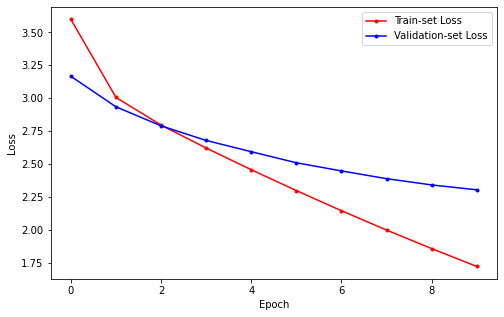

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
        
    return generated

In [69]:
generate_text(model, tokenizer, init_sentence="<start> am", max_len=20)

'<start> am i scary for you baby <end> '

In [70]:
generate_text(model, tokenizer, init_sentence="<start> talking", max_len=20)

'<start> talking to the moon <end> '

In [71]:
generate_text(model, tokenizer, init_sentence="<start> will", max_len=20)

'<start> will you still love me tomorrow <end> '

In [72]:
generate_text(model, tokenizer, init_sentence="<start> won t", max_len=20)

'<start> won t you give me a sign <end> '

## 최종 회고

- 첫번째, 두번째 시도외에도 여러가지 하이퍼 파라미터들을 조정하고, dropout 적용, learning_rate 변경 등 여러 수십가지 다양한 방법을 동원해서 `val_loss`를 **2.2**이하로 떨어뜨리기 위해 시도해 보았지만 실제 `val_loss` 값은 아래와 같은 범위에서 변동될 뿐이었다.  
>
>- `val_loss` 값 범위 : 약 **2.30 ~ 3.5** 사이였다.
>

- `val_loss` 향상이 되지 않아서 검색한 아래 사이트도 참고하여 변경/적용해 보았으나 결과는 위와 크게 달라지지 않았다.
    - ['val_loss' 향상 이휴 및 정확도 문제](https://lsjsj92.tistory.com/353) 

- padding 과 관련하여 검색하다가 아래 링크를 참조하여 padding 도 조정해 보았지만 생각처럼 되진 않았다.
    - [padding 관련 참고](https://blog.naver.com/qbxlvnf11/221945962124)
    
    
- 루브릭 기준에 **10** epochs 에 `val_loss` **2.2** 가 기준이어서 10 epochs 이상 시도해 보지 않았지만 프로젝트 제출후에 시도해 보려한다.
- 정확하게 무엇이 부족하거나 잘못되었기에 이렇게 밖에 안되는지 알 수가 없어서 답답하고 의기소침하게 되는 것 같다.
- 이 노드를 진행하면서 명확하게 분석해서 아는 분이 계시다면 자료 공유 및 어드바이스 부탁드리고 싶다.
- 앞으로 가야할 길이 멀었지만 더욱 멀게만 느껴지는 한 주를 보낸 것 같다.
